# Phase 3 - Mistral Extension - Hyperbolic Calibration ToC


This notebook extends the baseline by:
1. Loading XLM-RoBERTa variety router to detect English variety (British, Australian, Indian)
2. Using unified **Hyperbolic Calibration ToC prompts** for both sentiment and sarcasm:
   - **Sentiment**: Detects if exaggeration is literal praise (positive) or sarcastic (negative)
   - **Sarcasm**: Identifies regional irony and intensity mismatches
3. Analyzing cues:
   - Literal Cue (proportional phrasing)
   - Hyperbolic Cue (extreme intensity)
   - Contextual Mismatch (intensity applied to mundane/negative events)
4. Temperature-scaled retry mechanism for robust label extraction
5. Training and evaluating 9 models across sentiment and sarcasm tasks



# 1.Setup


## 1.1 Mount Google Drive and Install Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)


Mounted at /content/drive


In [ ]:
!pip install unsloth
!pip install datasets scikit-learn
!pip install bitsandbytes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.7/405.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 152.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
^C


## 1.2 Configuration and Imports


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import re
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from unsloth import FastLanguageModel
from transformers import TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification
from trl import SFTTrainer
from datasets import Dataset
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    confusion_matrix,
    f1_score
)

# Set device and random seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 50
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Using device: {device}")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Using device: cuda


In [ ]:
# Model configuration
MODEL_NAME = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit"
OUTPUT_DIR = "/content/drive/MyDrive/DNLP/models/mistral/mistral__TOC_HYPERBOLIC_besstie_outputs"
RESULTS_DIR = "/content/drive/MyDrive/DNLP/models/mistral/mistral__TOC_HYPERBOLIC_besstie_results"
MODELS_DIR = "/content/drive/MyDrive/DNLP/models/mistral/mistral__TOC_HYPERBOLIC_saved_models"

# XLM-RoBERTa Variety Router Path (Updated)
ROUTER_PATH = "/content/drive/MyDrive/DNLP/models/mistral/xlm_roberta_base"

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# CSV paths for split information
SENTIMENT_CSV = "/content/drive/MyDrive/DNLP/data/processed/sentiment/index_settings.csv"
SARCASM_CSV = "/content/drive/MyDrive/DNLP/data/processed/sarcasm/index_settings.csv"

# Training hyperparameters
MAX_EPOCHS = 3
LEARNING_RATE = 2e-4
BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 2
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.1
MAX_SEQ_LENGTH = 2028
# Temperature for generation
GENERATION_TEMPERATURE = 0.01

# Results storage paths
RESULTS_CSV = os.path.join(RESULTS_DIR, "all_results3.csv")
CONFUSION_MATRIX_CSV = os.path.join(RESULTS_DIR, "all_confusion_matrices3.csv")

# Variety mapping
VARIETY_MAP = {0: "British English", 1: "Australian English", 2: "Indian English"}

print("Configuration loaded!")


Configuration loaded!


## 1.3 Load XLM-RoBERTa Variety Router


In [ ]:
print("Loading XLM-RoBERTa variety router...")
router_tokenizer = AutoTokenizer.from_pretrained(ROUTER_PATH)
router_model = AutoModelForSequenceClassification.from_pretrained(ROUTER_PATH).to(device)
router_model.eval()

# Fix for missing pad token
if router_tokenizer.pad_token is None:
    router_tokenizer.pad_token_id = 1  # XLM-RoBERTa's <pad> token

print("Variety router loaded!")

def detect_variety(text: str) -> str:
    """Use XLM-RoBERTa to detect English variety."""
    inputs = router_tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        variety_id = torch.argmax(router_model(**inputs).logits, dim=-1).item()
    return VARIETY_MAP.get(variety_id, "English")


Loading XLM-RoBERTa variety router...
Variety router loaded!


## 1.4 Custom Exception for Label Extraction


In [ ]:
class LabelExtractionError(Exception):
    """Custom exception for label extraction failures"""
    pass


## 1.5 Data Loading Functions


In [ ]:
def load_split_info(csv_path: str) -> pd.DataFrame:
    """Load the split information CSV."""
    df = pd.read_csv(csv_path)
    print(f"Loaded split info from {csv_path}")
    print(f"Available settings: {df['setting'].tolist()}")
    return df

def load_data_from_csv(csv_path: str) -> pd.DataFrame:
    """Load data from a CSV file."""
    return pd.read_csv(csv_path)

def get_testsets_from_index(testsets_index_csv: str) -> List[str]:
    """Load test set CSV paths from the testsets index CSV."""
    test_index_df = pd.read_csv(testsets_index_csv)
    if 'csv' in test_index_df.columns:
        return test_index_df['csv'].tolist()
    else:
        return test_index_df.iloc[:, 1].tolist()

print("Data loading functions defined!")


Data loading functions defined!


## 1.6 Model Initialization Functions


In [ ]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    """Find all linear layer names for LoRA."""
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

def get_unsloth_model():
    """Initialize model with LoRA configuration."""
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=MODEL_NAME,
        max_seq_length=MAX_SEQ_LENGTH,
        load_in_4bit=True,
    )

    modules = find_all_linear_names(model)

    model = FastLanguageModel.get_peft_model(
        model,
        r=LORA_R,
        target_modules=modules,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        bias="none",
        use_gradient_checkpointing="unsloth",
        random_state=SEED,
    )
    return model, tokenizer

print("Model functions defined!")


Model functions defined!


## 1.7 Unified ToC Prompt with Hyperbolic Calibration


In [ ]:
def build_toc_prompt(text: str, task_type: str, variety_label: str) -> str:
    """
    Build the unified Hyperbolic Calibration ToC prompt for both sentiment and sarcasm.
    """
    if "sentiment" in task_type.lower():
        goal = "assign the TRUE sentiment by detecting if exaggeration is literal or sarcastic."
        decision_rule = (
            "- IF Step 1 shows Literal/Sincere praise -> Sentiment is 1.\n"
            "- IF Step 1 shows Hyperbolic/Exaggerated praise for a negative event -> Sentiment is 0."
        )
        labels = "0 = Negative, 1 = Positive"
    else:
        goal = "detect sarcasm by identifying regional irony and intensity mismatches."
        decision_rule = (
            "- IF Step 1 shows Literal language -> label 0 (Not Sarcastic).\n"
            "- IF Step 1 shows Hyperbolic intensity mismatch -> label 1 (Sarcastic)."
        )
        labels = "0 = Not Sarcastic, 1 = Sarcastic"

    prompt = f"""<s>[INST] You are a sociolinguistic analyst specializing in {variety_label} culture.
Your goal is to {goal}

Step 1: Analyze Cues:
- Literal Cue: Is the phrasing direct and proportional to the situation?
- Hyperbolic Cue: Does the text use extreme intensity or exaggeration (e.g., "absolute genius," "best ever")?
- Contextual Mismatch: Is that extreme intensity being applied to a mundane or negative {variety_label} event?

Step 2: Final Decision Rule:
{decision_rule}

Task: Only Just Provide the label ({labels}).
Text: "{text}" [/INST] {{"label":"""

    return prompt


## 1.8 Data Formatting Functions with Hyperbolic ToC


In [ ]:
def format_instruction(text: str, label: str, task_type: str, is_test: bool = False, variety_label: str = None) -> str:
    """Format text into instruction-following format with Hyperbolic ToC."""

    if variety_label is None:
        variety_label = detect_variety(text)

    # Build the ToC prompt
    prompt_base = build_toc_prompt(text, task_type, variety_label)

    if is_test:
        return prompt_base  # Ends with {"label":
    else:
        # For training, complete the JSON
        return prompt_base + f" {label}}}</s>"


def formatting_prompts_func(examples, task_type):
    """Format examples for training."""
    instructions = []
    for text, label in zip(examples['text'], examples['label']):
        full_text = format_instruction(text, str(label), task_type, is_test=False)
        instructions.append(full_text)
    return {"text": instructions}

print("Formatting functions with Hyperbolic ToC defined!")


Formatting functions with Hyperbolic ToC defined!


## 1.9 Evaluation Functions with Retry Mechanism


In [ ]:
def preprocess_logits_for_metrics(logits, labels):
    """Original logits are (batch_size, seq_len, vocab_size). Argmax to save memory."""
    if isinstance(logits, tuple):
        logits = logits[0]
    return logits.argmax(dim=-1)

def compute_metrics(eval_preds):
    """Calculate Macro-F1 for SFTTrainer."""
    predictions, labels = eval_preds
    mask = labels != -100
    labels = labels[mask]
    predictions = predictions[mask]
    macro_f1 = f1_score(labels, predictions, average='macro', zero_division=0)
    return {"f1": macro_f1}

print("Preprocess and compute_metrics functions defined!")


Preprocess and compute_metrics functions defined!


In [ ]:
def evaluate_model(model, tokenizer, test_data: pd.DataFrame, task_type: str) -> Tuple:
    """Evaluate model by processing each sample individually with retry mechanism."""
    model.eval()
    predictions = [None] * len(test_data)
    true_labels = test_data['label'].tolist()

    # Prepare inputs with variety detection
    prompts = []
    for text in test_data['text']:
        variety_label = detect_variety(text)
        prompt = format_instruction(text, "", task_type, is_test=True, variety_label=variety_label)
        prompts.append(prompt)

    # --- INDIVIDUAL PROCESSING ---
    print(f"Starting individual evaluation on {len(test_data)} samples...")
    FastLanguageModel.for_inference(model)

    for idx in tqdm(range(len(test_data)), desc="Individual Evaluation"):
        instruction = prompts[idx]
        inputs = tokenizer(instruction, return_tensors="pt", truncation=True, max_length=2048).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                pad_token_id=tokenizer.eos_token_id,
                temperature=0.01,
                do_sample=False,
                use_cache=True
            )

        decoded = tokenizer.decode(outputs[0], skip_special_tokens=False)

        try:
            # Extract from ToC JSON format: {"label": X}
            match = re.search(r'"label":\s*(\d)', decoded)
            if match:
                val = int(match.group(1))
                if val in [0, 1]:
                    predictions[idx] = val
            else:
                # Last resort - find last digit
                last_digit = re.findall(r'\d', decoded)
                if last_digit:
                    val = int(last_digit[-1])
                    if val in [0, 1]:
                        predictions[idx] = val
        except Exception:
            pass

    # --- RETRY LOGIC WITH TEMPERATURE SCALING ---
    failed_indices = [i for i, p in enumerate(predictions) if p is None]

    if failed_indices:
        print(f"Retrying {len(failed_indices)} failed predictions with temperature scaling...")
        temperatures = [0.01, 0.2, 0.4, 0.6, 0.8]

        for idx in tqdm(failed_indices, desc="Retry Loop"):
            instruction = prompts[idx]
            pred = None

            for attempt, temp in enumerate(temperatures):
                inputs = tokenizer(instruction, return_tensors="pt", truncation=True, max_length=2048).to(device)

                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=10,
                        pad_token_id=tokenizer.eos_token_id,
                        temperature=temp,
                        do_sample=(temp > 0.01)
                    )

                decoded = tokenizer.decode(outputs[0], skip_special_tokens=False)

                # Try label extraction
                match = re.search(r'"label":\s*(\d)', decoded)
                if match:
                    val = int(match.group(1))
                    if val in [0, 1]:
                        pred = val
                        break
                else:
                    last_digit = re.findall(r'\d', decoded)
                    if last_digit:
                        val = int(last_digit[-1])
                        if val in [0, 1]:
                            pred = val
                            break

            predictions[idx] = pred if pred is not None else 0

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro', zero_division=0
    )
    accuracy = accuracy_score(true_labels, predictions)

    return predictions, true_labels, precision, recall, accuracy, f1

In [ ]:
def save_results_to_csv(results: List[Dict], filepath: str):
    """Save results to CSV file by appending on disk."""
    df = pd.DataFrame(results)
    file_exists = os.path.isfile(filepath)
    df.to_csv(filepath, mode='a', index=False, header=not file_exists)
    print(f"Results {'appended to' if file_exists else 'saved to'} {filepath}")

def save_confusion_matrix_to_csv(cm_data: List[Dict], filepath: str):
    """Save confusion matrix data to CSV file by appending on disk."""
    df = pd.DataFrame(cm_data)
    file_exists = os.path.isfile(filepath)
    df.to_csv(filepath, mode='a', index=False, header=not file_exists)
    print(f"Confusion matrices {'appended to' if file_exists else 'saved to'} {filepath}")


## 1.10 Main Training Function


In [ ]:
def train_and_evaluate_model(
    task: str,
    train_setting: str,
    test_settings: List[Tuple[str, List[str]]],
    split_info_df: pd.DataFrame,
    variant_name: str,
    debug: bool = False,
    skip_training: bool = False,
    skip_evaluation: bool = False
):
    print(f"\n{'='*80}\nModel Variant: {variant_name}\n{'='*80}\n")

    model_save_path = os.path.join(MODELS_DIR, variant_name)
    model_exists = os.path.exists(model_save_path) and os.path.exists(os.path.join(model_save_path, "adapter_config.json"))

    model = None
    tokenizer = None

    # --- TRAINING PHASE ---
    if skip_training and model_exists:
        print(f"✓ Model found at {model_save_path}")
    else:
        train_row = split_info_df[split_info_df['setting'] == train_setting].iloc[0]
        train_df = load_data_from_csv(train_row['train_csv'])
        val_df = load_data_from_csv(train_row['val_csv'])

        if debug:
            train_df, val_df = train_df.head(64), val_df.head(64)

        train_dataset = Dataset.from_pandas(train_df).map(lambda x: formatting_prompts_func(x, task), batched=True)
        val_dataset = Dataset.from_pandas(val_df).map(lambda x: formatting_prompts_func(x, task), batched=True)

        model, tokenizer = get_unsloth_model()

        training_args = TrainingArguments(
            output_dir=os.path.join(OUTPUT_DIR, f"{variant_name}_checkpoints"),
            num_train_epochs=MAX_EPOCHS,
            per_device_train_batch_size=BATCH_SIZE,
            gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
            learning_rate=LEARNING_RATE,
            logging_steps=10,
            save_strategy="epoch",
            eval_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            warmup_steps=100,
            bf16=True,
            tf32=True,
            report_to="none",
            seed=SEED,
        )

        trainer = SFTTrainer(
            model=model,
            tokenizer=tokenizer,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            args=training_args,
            dataset_text_field="text",
            max_seq_length=MAX_SEQ_LENGTH,
            packing=False,
        )

        trainer.train()
        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        del trainer
        torch.cuda.empty_cache()

    # --- EVALUATION PHASE ---
    results_list = []
    cm_list = []

    if skip_evaluation:
        print("\n⏭ skip_evaluation=True: Skipping evaluation phase.")
    else:
        print(f"\n{'='*80}")
        print(f"EVALUATION PHASE")
        print(f"{'='*80}")

        if model is None:
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name=model_save_path,
                max_seq_length=MAX_SEQ_LENGTH,
                dtype=None,
                load_in_4bit=True,
            )
            FastLanguageModel.for_inference(model)

        for test_setting_name, test_csv_paths in test_settings:
            if isinstance(test_csv_paths, str):
                test_csv_paths = [test_csv_paths]

            for idx, test_csv_path in enumerate(test_csv_paths):
                test_file_name = os.path.basename(test_csv_path)
                print(f"\n  Evaluating on: {test_file_name}")

                test_df = load_data_from_csv(test_csv_path)
                if debug:
                    test_df = test_df.head(10)

                predictions, true_labels, precision, recall, accuracy, f1 = evaluate_model(
                    model, tokenizer, test_df, task
                )

                result = {
                    'task': task, 'variant': variant_name, 'train_setting': train_setting,
                    'test_setting': test_file_name, 'test_file': test_csv_path,
                    'precision': precision, 'recall': recall, 'accuracy': accuracy, 'f1': f1
                }
                results_list.append(result)

                cm = confusion_matrix(true_labels, predictions)
                cm_data = {
                    'task': task, 'variant': variant_name, 'train_setting': train_setting,
                    'test_setting': test_file_name, 'tn': int(cm[0, 0]), 'fp': int(cm[0, 1]),
                    'fn': int(cm[1, 0]), 'tp': int(cm[1, 1])
                }
                cm_list.append(cm_data)

        save_results_to_csv(results_list, RESULTS_CSV)
        save_confusion_matrix_to_csv(cm_list, CONFUSION_MATRIX_CSV)

    if model is not None:
        del model
        torch.cuda.empty_cache()

    return results_list, cm_list

## 1.11 Load Split Information


In [ ]:
sentiment_splits = load_split_info(SENTIMENT_CSV)
sarcasm_splits = load_split_info(SARCASM_CSV)

print("\nSentiment splits:")
display(sentiment_splits)
print("\nSarcasm splits:")
display(sarcasm_splits)


Loaded split info from /content/drive/MyDrive/DNLP/data/processed/sentiment/index_settings.csv
Available settings: ['Google', 'Reddit', 'TRAIN_en-AU', 'TRAIN_en-IN', 'TRAIN_en-UK']
Loaded split info from /content/drive/MyDrive/DNLP/data/processed/sarcasm/index_settings.csv
Available settings: ['FULL', 'TRAIN_en-AU', 'TRAIN_en-IN', 'TRAIN_en-UK']

Sentiment splits:


,task,setting,train_csv,val_csv,splits_json,testsets_index_csv,n_train,n_val
0,sentiment,Google,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,3529,882
1,sentiment,Reddit,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,3564,891
2,sentiment,TRAIN_en-AU,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,2167,542
3,sentiment,TRAIN_en-IN,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,2667,666
4,sentiment,TRAIN_en-UK,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,2259,565



Sarcasm splits:


,task,setting,train_csv,val_csv,splits_json,testsets_index_csv,n_train,n_val
0,sarcasm,FULL,/content/drive/MyDrive/DNLP/data/processed/sar...,/content/drive/MyDrive/DNLP/data/processed/sar...,/content/drive/MyDrive/DNLP/data/splits/sarcas...,/content/drive/MyDrive/DNLP/data/processed/sar...,3585,895
1,sarcasm,TRAIN_en-AU,/content/drive/MyDrive/DNLP/data/processed/sar...,/content/drive/MyDrive/DNLP/data/processed/sar...,/content/drive/MyDrive/DNLP/data/splits/sarcas...,/content/drive/MyDrive/DNLP/data/processed/sar...,1411,352
2,sarcasm,TRAIN_en-IN,/content/drive/MyDrive/DNLP/data/processed/sar...,/content/drive/MyDrive/DNLP/data/processed/sar...,/content/drive/MyDrive/DNLP/data/splits/sarcas...,/content/drive/MyDrive/DNLP/data/processed/sar...,1349,337
3,sarcasm,TRAIN_en-UK,/content/drive/MyDrive/DNLP/data/processed/sar...,/content/drive/MyDrive/DNLP/data/processed/sar...,/content/drive/MyDrive/DNLP/data/splits/sarcas...,/content/drive/MyDrive/DNLP/data/processed/sar...,825,206


In [ ]:
# Get test paths for evaluation
google_row = sentiment_splits[sentiment_splits['setting'] == 'Google'].iloc[0]
reddit_row = sentiment_splits[sentiment_splits['setting'] == 'Reddit'].iloc[0]
sarcasm_full_row = sarcasm_splits[sarcasm_splits['setting'] == 'FULL'].iloc[0]

google_test_paths = get_testsets_from_index(google_row['testsets_index_csv'])
reddit_test_paths = get_testsets_from_index(reddit_row['testsets_index_csv'])
sarcasm_test_paths = get_testsets_from_index(sarcasm_full_row['testsets_index_csv'])

print(f"Found {len(google_test_paths)} Google sentiment test paths")
print(f"Found {len(reddit_test_paths)} Reddit sentiment test paths")
print(f"Found {len(sarcasm_test_paths)} sarcasm test paths")


Found 6 Google sentiment test paths
Found 6 Reddit sentiment test paths
Found 4 sarcasm test paths


# 2. Pre-trained Model Testing with Hyperbolic ToC

This section evaluates models using the Hyperbolic Calibration ToC (Tensor of Cues) prompting method. It tests the original pre-trained Mistral model on all test sets without any fine-tuning.


In [ ]:
if __name__ == "__main__":
    DEBUG_MODE = False
    DEBUG_ROWS = 10

    print("="*80)
    print("TESTING PRE-TRAINED MODEL (NO FINE-TUNING) WITH HYPERBOLIC ToC")
    if DEBUG_MODE:
        print(f"🐛 DEBUG MODE: Testing only first {DEBUG_ROWS} rows")
    print("="*80)

    print("\nLoading pre-trained model...")
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=MODEL_NAME,
        max_seq_length=MAX_SEQ_LENGTH,
        load_in_4bit=True,
    )

    results_list = []
    cm_list = []

    # Test on SENTIMENT test sets
    print("\n" + "="*80)
    print("TESTING ON SENTIMENT DATASETS (WITH HYPERBOLIC ToC)")
    print("="*80)

    sentiment_row = sentiment_splits.iloc[0]
    testsets_index_csv = sentiment_row['testsets_index_csv']
    test_paths = get_testsets_from_index(testsets_index_csv)

    print(f"\nFound {len(test_paths)} sentiment test sets")

    for test_csv_path in test_paths:
        test_name = test_csv_path.split('/')[-1].replace('.csv', '')
        print(f"\nTesting on sentiment - {test_name}...")

        test_df = load_data_from_csv(test_csv_path)
        if DEBUG_MODE:
            test_df = test_df.head(DEBUG_ROWS)
        else:
            print(f"Test samples: {len(test_df)}")

        predictions, true_labels, precision, recall, accuracy, f1 = evaluate_model(
            model, tokenizer, test_df, 'sentiment'
        )

        result = {
            'task': 'sentiment', 'variant': 'PRETRAINED_HYPERBOLIC_TOC',
            'train_setting': 'NONE', 'test_setting': test_name,
            'precision': precision, 'recall': recall, 'accuracy': accuracy, 'f1': f1
        }
        results_list.append(result)
        print(f"Results: Precision={precision:.4f}, Recall={recall:.4f}, Accuracy={accuracy:.4f}, F1={f1:.4f}")

        cm = confusion_matrix(true_labels, predictions)
        cm_list.append({
            'task': 'sentiment', 'variant': 'PRETRAINED_HYPERBOLIC_TOC',
            'train_setting': 'NONE', 'test_setting': test_name,
            'tn': int(cm[0,0]), 'fp': int(cm[0,1]), 'fn': int(cm[1,0]), 'tp': int(cm[1,1])
        })

    # Test on SARCASM test sets
    print("\n" + "="*80)
    print("TESTING ON SARCASM DATASETS (WITH HYPERBOLIC ToC)")
    print("="*80)

    sarcasm_row = sarcasm_splits.iloc[0]
    testsets_index_csv = sarcasm_row['testsets_index_csv']
    test_paths = get_testsets_from_index(testsets_index_csv)

    print(f"\nFound {len(test_paths)} sarcasm test sets")

    for test_csv_path in test_paths:
        test_name = test_csv_path.split('/')[-1].replace('.csv', '')
        print(f"\nTesting on sarcasm - {test_name}...")

        test_df = load_data_from_csv(test_csv_path)
        if DEBUG_MODE:
            test_df = test_df.head(DEBUG_ROWS)
        else:
            print(f"Test samples: {len(test_df)}")

        predictions, true_labels, precision, recall, accuracy, f1 = evaluate_model(
            model, tokenizer, test_df, 'sarcasm'
        )

        result = {
            'task': 'sarcasm', 'variant': 'PRETRAINED_HYPERBOLIC_TOC',
            'train_setting': 'NONE', 'test_setting': test_name,
            'precision': precision, 'recall': recall, 'accuracy': accuracy, 'f1': f1
        }
        results_list.append(result)
        print(f"Results: Precision={precision:.4f}, Recall={recall:.4f}, Accuracy={accuracy:.4f}, F1={f1:.4f}")

        cm = confusion_matrix(true_labels, predictions)
        cm_list.append({
            'task': 'sarcasm', 'variant': 'PRETRAINED_HYPERBOLIC_TOC',
            'train_setting': 'NONE', 'test_setting': test_name,
            'tn': int(cm[0,0]), 'fp': int(cm[0,1]), 'fn': int(cm[1,0]), 'tp': int(cm[1,1])
        })

    # Save results
    print("\n" + "="*80)
    print("SAVING RESULTS")
    print("="*80)
    os.makedirs(os.path.dirname(RESULTS_CSV), exist_ok=True)
    save_results_to_csv(results_list, RESULTS_CSV)
    save_confusion_matrix_to_csv(cm_list, CONFUSION_MATRIX_CSV)

    del model
    torch.cuda.empty_cache()
    print(f"\n✅ Pre-trained model testing complete! Total tests: {len(results_list)}")


TESTING PRE-TRAINED MODEL (NO FINE-TUNING) WITH HYPERBOLIC ToC

Loading pre-trained model...
==((====))==  Unsloth 2026.1.4: Fast Mistral patching. Transformers: 4.57.6.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

TESTING ON SENTIMENT DATASETS (WITH HYPERBOLIC ToC)

Found 6 sentiment test sets

Testing on sentiment - TEST_FULL...
Test samples: 1212
Starting individual evaluation on 1212 samples...


Individual Evaluation:   0%|          | 0/1212 [00:00<?, ?it/s]

Results: Precision=0.8692, Recall=0.8628, Accuracy=0.8622, F1=0.8617

Testing on sentiment - TEST_google...
Test samples: 603
Starting individual evaluation on 603 samples...


Individual Evaluation:   0%|          | 0/603 [00:00<?, ?it/s]

Results: Precision=0.9054, Recall=0.8798, Accuracy=0.9204, F1=0.8916

Testing on sentiment - TEST_reddit...
Test samples: 609
Starting individual evaluation on 609 samples...


Individual Evaluation:   0%|          | 0/609 [00:00<?, ?it/s]

Results: Precision=0.7550, Recall=0.8168, Accuracy=0.8046, F1=0.7701

Testing on sentiment - TEST_en-au...
Test samples: 371
Starting individual evaluation on 371 samples...


Individual Evaluation:   0%|          | 0/371 [00:00<?, ?it/s]

Results: Precision=0.8550, Recall=0.8499, Accuracy=0.8437, F1=0.8435

Testing on sentiment - TEST_en-in...
Test samples: 455
Starting individual evaluation on 455 samples...


Individual Evaluation:   0%|          | 0/455 [00:00<?, ?it/s]

Results: Precision=0.8487, Recall=0.8443, Accuracy=0.8440, F1=0.8435

Testing on sentiment - TEST_en-uk...
Test samples: 386
Starting individual evaluation on 386 samples...


Individual Evaluation:   0%|          | 0/386 [00:00<?, ?it/s]

Results: Precision=0.9072, Recall=0.8989, Accuracy=0.9016, F1=0.9006

TESTING ON SARCASM DATASETS (WITH HYPERBOLIC ToC)

Found 4 sarcasm test sets

Testing on sarcasm - TEST_FULL...
Test samples: 612
Starting individual evaluation on 612 samples...


Individual Evaluation:   0%|          | 0/612 [00:00<?, ?it/s]

Results: Precision=0.5774, Recall=0.5601, Accuracy=0.4003, F1=0.3965

Testing on sarcasm - TEST_en-au...
Test samples: 241
Starting individual evaluation on 241 samples...


Individual Evaluation:   0%|          | 0/241 [00:00<?, ?it/s]

Results: Precision=0.6577, Recall=0.6263, Accuracy=0.5851, F1=0.5750

Testing on sarcasm - TEST_en-in...
Test samples: 230
Starting individual evaluation on 230 samples...


Individual Evaluation:   0%|          | 0/230 [00:00<?, ?it/s]

Results: Precision=0.5159, Recall=0.5184, Accuracy=0.2609, F1=0.2604

Testing on sarcasm - TEST_en-uk...
Test samples: 141
Starting individual evaluation on 141 samples...


Individual Evaluation:   0%|          | 0/141 [00:00<?, ?it/s]

Results: Precision=0.6211, Recall=0.5591, Accuracy=0.3121, F1=0.3007

SAVING RESULTS
Results saved to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_results3.csv
Confusion matrices saved to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_confusion_matrices3.csv

✅ Pre-trained model testing complete! Total tests: 10


# 3. Fine-tuning Models using ToC

Train models using the Hyperbolic Calibration ToC (Tensor of Cues) prompting method.


## 3.1 Sentiment Models

### MODEL 1: Google Sentiment (with Hyperbolic ToC)
Train on Google Sentiment train set, test on:
1. Google test set
2. Reddit test set (cross-domain)

In [ ]:
test_settings_model1 = [('Google', google_test_paths)]
train_and_evaluate_model(
    task='sentiment', train_setting='Google',
    test_settings=test_settings_model1, split_info_df=sentiment_splits,
    variant_name='HypToC_Sent_Google', skip_training=True



Model Variant: HypToC_Sent_Google

✓ Model found at /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_saved_models/HypToC_Sent_Google

EVALUATION PHASE
==((====))==  Unsloth 2026.1.4: Fast Mistral patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

  Evaluating on: TEST_FULL.csv
Starting individual evaluation on 1212 samples...


Individual Evaluation:   0%|          | 0/1212 [00:00<?, ?it/s]


  Evaluating on: TEST_google.csv
Starting individual evaluation on 603 samples...


Individual Evaluation:   0%|          | 0/603 [00:00<?, ?it/s]


  Evaluating on: TEST_reddit.csv
Starting individual evaluation on 609 samples...


Individual Evaluation:   0%|          | 0/609 [00:00<?, ?it/s]


  Evaluating on: TEST_en-au.csv
Starting individual evaluation on 371 samples...


Individual Evaluation:   0%|          | 0/371 [00:00<?, ?it/s]


  Evaluating on: TEST_en-in.csv
Starting individual evaluation on 455 samples...


Individual Evaluation:   0%|          | 0/455 [00:00<?, ?it/s]


  Evaluating on: TEST_en-uk.csv
Starting individual evaluation on 386 samples...


Individual Evaluation:   0%|          | 0/386 [00:00<?, ?it/s]

Results appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_results3.csv
Confusion matrices appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_confusion_matrices3.csv


([{'task': 'sentiment',
   'variant': 'HypToC_Sent_Google',
   'train_setting': 'Google',
   'test_setting': 'TEST_FULL.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_FULL.csv',
   'precision': 0.8940098873935732,
   'recall': 0.8906718480655536,
   'accuracy': 0.8902640264026402,
   'f1': 0.8900693766738068},
  {'task': 'sentiment',
   'variant': 'HypToC_Sent_Google',
   'train_setting': 'Google',
   'test_setting': 'TEST_google.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_google.csv',
   'precision': 0.9364612132053993,
   'recall': 0.8898039215686275,
   'accuracy': 0.9353233830845771,
   'f1': 0.9099686457970437},
  {'task': 'sentiment',
   'variant': 'HypToC_Sent_Google',
   'train_setting': 'Google',
   'test_setting': 'TEST_reddit.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_reddit.csv',
   'precision': 0.7920634920634921,
   'recall': 0.8352323664

### MODEL 2: Reddit Sentiment (with Hyperbolic ToC)
Train on Reddit Sentiment train set, test on:
1. Reddit test set
2. Google test set (cross-domain)

In [ ]:
test_settings_model2 = [('Reddit', reddit_test_paths)]
train_and_evaluate_model(
    task='sentiment', train_setting='Reddit',
    test_settings=test_settings_model2, split_info_df=sentiment_splits,
    variant_name='HypToC_Sent_Reddit', skip_training=True
)



Model Variant: HypToC_Sent_Reddit



Map:   0%|          | 0/3564 [00:00<?, ? examples/s]

Map:   0%|          | 0/891 [00:00<?, ? examples/s]

==((====))==  Unsloth 2026.1.4: Fast Mistral patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/3564 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/891 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,564 | Num Epochs = 3 | Total steps = 1,338
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 7,289,966,592 (0.58% trained)


Epoch,Training Loss,Validation Loss
1,0.553600,0.586367
2,0.439100,0.618180
3,0.219800,0.719382



EVALUATION PHASE

  Evaluating on: TEST_FULL.csv
Starting batch evaluation on 1212 samples with batch_size=16...


Batch Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Retrying 49 failed predictions with temperature scaling...


Retry Loop:   0%|          | 0/49 [00:00<?, ?it/s]


  Evaluating on: TEST_google.csv
Starting batch evaluation on 603 samples with batch_size=16...


Batch Evaluation:   0%|          | 0/38 [00:00<?, ?it/s]

Retrying 31 failed predictions with temperature scaling...


Retry Loop:   0%|          | 0/31 [00:00<?, ?it/s]


  Evaluating on: TEST_reddit.csv
Starting batch evaluation on 609 samples with batch_size=16...


Batch Evaluation:   0%|          | 0/39 [00:00<?, ?it/s]

Retrying 13 failed predictions with temperature scaling...


Retry Loop:   0%|          | 0/13 [00:00<?, ?it/s]


  Evaluating on: TEST_en-au.csv
Starting batch evaluation on 371 samples with batch_size=16...


Batch Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Retrying 12 failed predictions with temperature scaling...


Retry Loop:   0%|          | 0/12 [00:00<?, ?it/s]


  Evaluating on: TEST_en-in.csv
Starting batch evaluation on 455 samples with batch_size=16...


Batch Evaluation:   0%|          | 0/29 [00:00<?, ?it/s]

Retrying 11 failed predictions with temperature scaling...


Retry Loop:   0%|          | 0/11 [00:00<?, ?it/s]


  Evaluating on: TEST_en-uk.csv
Starting batch evaluation on 386 samples with batch_size=16...


Batch Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

Retrying 20 failed predictions with temperature scaling...


Retry Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Results appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_results.csv
Confusion matrices appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_confusion_matrices.csv


([{'task': 'sentiment',
   'variant': 'HypToC_Sent_Reddit',
   'train_setting': 'Reddit',
   'test_setting': 'TEST_FULL.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_FULL.csv',
   'precision': 0.7247727427597956,
   'recall': 0.7245670745157416,
   'accuracy': 0.7244224422442245,
   'f1': 0.7243856672485682},
  {'task': 'sentiment',
   'variant': 'HypToC_Sent_Reddit',
   'train_setting': 'Reddit',
   'test_setting': 'TEST_google.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_google.csv',
   'precision': 0.7150433394160585,
   'recall': 0.7464705882352941,
   'accuracy': 0.7761194029850746,
   'f1': 0.7259506135434025},
  {'task': 'sentiment',
   'variant': 'HypToC_Sent_Reddit',
   'train_setting': 'Reddit',
   'test_setting': 'TEST_reddit.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_reddit.csv',
   'precision': 0.6163821954484605,
   'recall': 0.6508502270

### MODEL 3: en-AU Sentiment (with Hyperbolic ToC)
Train on en-AU Sentiment train set, test on:
1. Google (cross-variety)
2. Reddit (cross-variety)
3. en-AU test set
4. en-IN test set (cross-variety)
5. en-UK test set (cross-variety)


In [ ]:
train_and_evaluate_model(
    task='sentiment', train_setting='TRAIN_en-AU',
    test_settings=[('en-AU', google_test_paths)], split_info_df=sentiment_splits,
    variant_name='HypToC_Sent_enAU', skip_training=False
)



Model Variant: HypToC_Sent_enAU

✓ Model found at /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_saved_models/HypToC_Sent_enAU

EVALUATION PHASE
==((====))==  Unsloth 2026.1.4: Fast Mistral patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

  Evaluating on: TEST_FULL.csv
Starting individual evaluation on 1212 samples...


Individual Evaluation:   0%|          | 0/1212 [00:00<?, ?it/s]


  Evaluating on: TEST_google.csv
Starting individual evaluation on 603 samples...


Individual Evaluation:   0%|          | 0/603 [00:00<?, ?it/s]


  Evaluating on: TEST_reddit.csv
Starting individual evaluation on 609 samples...


Individual Evaluation:   0%|          | 0/609 [00:00<?, ?it/s]


  Evaluating on: TEST_en-au.csv
Starting individual evaluation on 371 samples...


Individual Evaluation:   0%|          | 0/371 [00:00<?, ?it/s]


  Evaluating on: TEST_en-in.csv
Starting individual evaluation on 455 samples...


Individual Evaluation:   0%|          | 0/455 [00:00<?, ?it/s]


  Evaluating on: TEST_en-uk.csv
Starting individual evaluation on 386 samples...


Individual Evaluation:   0%|          | 0/386 [00:00<?, ?it/s]

Results appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_results3.csv
Confusion matrices appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_confusion_matrices3.csv


([{'task': 'sentiment',
   'variant': 'HypToC_Sent_enAU',
   'train_setting': 'TRAIN_en-AU',
   'test_setting': 'TEST_FULL.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_FULL.csv',
   'precision': 0.9133571156255106,
   'recall': 0.9133672466238756,
   'accuracy': 0.9133663366336634,
   'f1': 0.913361559246846},
  {'task': 'sentiment',
   'variant': 'HypToC_Sent_enAU',
   'train_setting': 'TRAIN_en-AU',
   'test_setting': 'TEST_google.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_google.csv',
   'precision': 0.9353271259647384,
   'recall': 0.8571895424836602,
   'accuracy': 0.9220563847429519,
   'f1': 0.8875593625150267},
  {'task': 'sentiment',
   'variant': 'HypToC_Sent_enAU',
   'train_setting': 'TRAIN_en-AU',
   'test_setting': 'TEST_reddit.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_reddit.csv',
   'precision': 0.9046030628410491,
   'recall': 0.83

### MODEL 4: en-IN Sentiment (with Hyperbolic ToC)
Train on en-IN Sentiment train set, test on:
1. Google (cross-variety)
2. Reddit (cross-variety)
3. en-AU test set(cross-variety)
4. en-IN test set
5. en-UK test set (cross-variety)

In [ ]:
train_and_evaluate_model(
    task='sentiment', train_setting='TRAIN_en-IN',
    test_settings=[('en-IN', google_test_paths)], split_info_df=sentiment_splits,
    variant_name='HypToC_Sent_enIN', skip_training=False
)



Model Variant: HypToC_Sent_enIN

✓ Model found at /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_saved_models/HypToC_Sent_enIN

EVALUATION PHASE
==((====))==  Unsloth 2026.1.4: Fast Mistral patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

  Evaluating on: TEST_FULL.csv
Starting individual evaluation on 1212 samples...


Individual Evaluation:   0%|          | 0/1212 [00:00<?, ?it/s]


  Evaluating on: TEST_google.csv
Starting individual evaluation on 603 samples...


Individual Evaluation:   0%|          | 0/603 [00:00<?, ?it/s]


  Evaluating on: TEST_reddit.csv
Starting individual evaluation on 609 samples...


Individual Evaluation:   0%|          | 0/609 [00:00<?, ?it/s]


  Evaluating on: TEST_en-au.csv
Starting individual evaluation on 371 samples...


Individual Evaluation:   0%|          | 0/371 [00:00<?, ?it/s]


  Evaluating on: TEST_en-in.csv
Starting individual evaluation on 455 samples...


Individual Evaluation:   0%|          | 0/455 [00:00<?, ?it/s]


  Evaluating on: TEST_en-uk.csv
Starting individual evaluation on 386 samples...


Individual Evaluation:   0%|          | 0/386 [00:00<?, ?it/s]

Results appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_results3.csv
Confusion matrices appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_confusion_matrices3.csv


([{'task': 'sentiment',
   'variant': 'HypToC_Sent_enIN',
   'train_setting': 'TRAIN_en-IN',
   'test_setting': 'TEST_FULL.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_FULL.csv',
   'precision': 0.9125486468747532,
   'recall': 0.912521683718625,
   'accuracy': 0.9125412541254125,
   'f1': 0.912532679738562},
  {'task': 'sentiment',
   'variant': 'HypToC_Sent_enIN',
   'train_setting': 'TRAIN_en-IN',
   'test_setting': 'TEST_google.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_google.csv',
   'precision': 0.9138560042196566,
   'recall': 0.9102614379084968,
   'accuracy': 0.9336650082918739,
   'f1': 0.9120375773135723},
  {'task': 'sentiment',
   'variant': 'HypToC_Sent_enIN',
   'train_setting': 'TRAIN_en-IN',
   'test_setting': 'TEST_reddit.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_reddit.csv',
   'precision': 0.8566790352504638,
   'recall': 0.850

### MODEL 5: en-UK Sentiment (with Hyperbolic ToC)
Train on en-UK Sentiment train set, test on:
1. Google (cross-variety)
2. Reddit (cross-variety)
3. en-AU test set(cross-variety)
4. en-IN test set (cross-variety)
5. en-UK test set


In [ ]:
train_and_evaluate_model(
    task='sentiment', train_setting='TRAIN_en-UK',
    test_settings=[('en-UK', google_test_paths)], split_info_df=sentiment_splits,
    variant_name='HypToC_Sent_enUK', skip_training=True
)



Model Variant: HypToC_Sent_enUK

✓ Model found at /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_saved_models/HypToC_Sent_enUK

EVALUATION PHASE
==((====))==  Unsloth 2026.1.4: Fast Mistral patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

  Evaluating on: TEST_FULL.csv
Starting individual evaluation on 1212 samples...


Individual Evaluation:   0%|          | 0/1212 [00:00<?, ?it/s]


  Evaluating on: TEST_google.csv
Starting individual evaluation on 603 samples...


Individual Evaluation:   0%|          | 0/603 [00:00<?, ?it/s]


  Evaluating on: TEST_reddit.csv
Starting individual evaluation on 609 samples...


Individual Evaluation:   0%|          | 0/609 [00:00<?, ?it/s]


  Evaluating on: TEST_en-au.csv
Starting individual evaluation on 371 samples...


Individual Evaluation:   0%|          | 0/371 [00:00<?, ?it/s]


  Evaluating on: TEST_en-in.csv
Starting individual evaluation on 455 samples...


Individual Evaluation:   0%|          | 0/455 [00:00<?, ?it/s]


  Evaluating on: TEST_en-uk.csv
Starting individual evaluation on 386 samples...


Individual Evaluation:   0%|          | 0/386 [00:00<?, ?it/s]

Results appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_results3.csv
Confusion matrices appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_confusion_matrices3.csv


([{'task': 'sentiment',
   'variant': 'HypToC_Sent_enUK',
   'train_setting': 'TRAIN_en-UK',
   'test_setting': 'TEST_FULL.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_FULL.csv',
   'precision': 0.9150073525407113,
   'recall': 0.9150175239848479,
   'accuracy': 0.915016501650165,
   'f1': 0.9150118152611919},
  {'task': 'sentiment',
   'variant': 'HypToC_Sent_enUK',
   'train_setting': 'TRAIN_en-UK',
   'test_setting': 'TEST_google.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_google.csv',
   'precision': 0.9409571002366175,
   'recall': 0.8735294117647059,
   'accuracy': 0.9303482587064676,
   'f1': 0.9008254753923749},
  {'task': 'sentiment',
   'variant': 'HypToC_Sent_enUK',
   'train_setting': 'TRAIN_en-UK',
   'test_setting': 'TEST_reddit.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sentiment/testsets/TEST_reddit.csv',
   'precision': 0.8904652351738241,
   'recall': 0.83

## 3.2 Sarcasm Models

### MODEL 6: FULL Sarcasm (with Hyperbolic ToC)
Train on Reddit Sarcasm train set, test on:
1. Reddit(full) test set
2. en-AU test set
3. en-IN test set
4. en-UK test set

In [ ]:
train_and_evaluate_model(
    task='sarcasm', train_setting='FULL',
    test_settings=[('FULL', sarcasm_test_paths)], split_info_df=sarcasm_splits,
    variant_name='HypToC_Sarc_FULL', skip_training=True
)



Model Variant: HypToC_Sarc_FULL

✓ Model found at /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_saved_models/HypToC_Sarc_FULL

EVALUATION PHASE
==((====))==  Unsloth 2026.1.4: Fast Mistral patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

Unsloth 2026.1.4 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.



  Evaluating on: TEST_FULL.csv
Starting individual evaluation on 612 samples...


Individual Evaluation:   0%|          | 0/612 [00:00<?, ?it/s]


  Evaluating on: TEST_en-au.csv
Starting individual evaluation on 241 samples...


Individual Evaluation:   0%|          | 0/241 [00:00<?, ?it/s]


  Evaluating on: TEST_en-in.csv
Starting individual evaluation on 230 samples...


Individual Evaluation:   0%|          | 0/230 [00:00<?, ?it/s]


  Evaluating on: TEST_en-uk.csv
Starting individual evaluation on 141 samples...


Individual Evaluation:   0%|          | 0/141 [00:00<?, ?it/s]

Results appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_results3.csv
Confusion matrices appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_confusion_matrices3.csv


([{'task': 'sarcasm',
   'variant': 'HypToC_Sarc_FULL',
   'train_setting': 'FULL',
   'test_setting': 'TEST_FULL.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_FULL.csv',
   'precision': 0.7303039569445293,
   'recall': 0.757265634607239,
   'accuracy': 0.7843137254901961,
   'f1': 0.7402777777777778},
  {'task': 'sarcasm',
   'variant': 'HypToC_Sarc_FULL',
   'train_setting': 'FULL',
   'test_setting': 'TEST_en-au.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_en-au.csv',
   'precision': 0.7508020644441344,
   'recall': 0.7543140028288543,
   'accuracy': 0.7385892116182573,
   'f1': 0.738427082436041},
  {'task': 'sarcasm',
   'variant': 'HypToC_Sarc_FULL',
   'train_setting': 'FULL',
   'test_setting': 'TEST_en-in.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_en-in.csv',
   'precision': 0.6354522670312144,
   'recall': 0.5963689414816016,
   'accuracy': 0.84347

### MODEL 7: en-AU Sarcasm (with Hyperbolic ToC)

Train on en-AU Sarcasm train set, test on:
1. Reddit test set (cross-variety)
2. en-AU test set
3. en-IN test set (cross-variety)
4. en-UK test set (cross-variety)

In [ ]:
train_and_evaluate_model(
    task='sarcasm', train_setting='TRAIN_en-AU',
    test_settings=[('en-AU', sarcasm_test_paths)], split_info_df=sarcasm_splits,
    variant_name='HypToC_Sarc_enAU', skip_training=True
)



Model Variant: HypToC_Sarc_enAU

✓ Model found at /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_saved_models/HypToC_Sarc_enAU

EVALUATION PHASE
==((====))==  Unsloth 2026.1.4: Fast Mistral patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

  Evaluating on: TEST_FULL.csv
Starting individual evaluation on 612 samples...


Individual Evaluation:   0%|          | 0/612 [00:00<?, ?it/s]


  Evaluating on: TEST_en-au.csv
Starting individual evaluation on 241 samples...


Individual Evaluation:   0%|          | 0/241 [00:00<?, ?it/s]


  Evaluating on: TEST_en-in.csv
Starting individual evaluation on 230 samples...


Individual Evaluation:   0%|          | 0/230 [00:00<?, ?it/s]


  Evaluating on: TEST_en-uk.csv
Starting individual evaluation on 141 samples...


Individual Evaluation:   0%|          | 0/141 [00:00<?, ?it/s]

Results appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_results3.csv
Confusion matrices appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_confusion_matrices3.csv


([{'task': 'sarcasm',
   'variant': 'HypToC_Sarc_enAU',
   'train_setting': 'TRAIN_en-AU',
   'test_setting': 'TEST_FULL.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_FULL.csv',
   'precision': 0.635188679245283,
   'recall': 0.6566398404088158,
   'accuracy': 0.5506535947712419,
   'f1': 0.547754492224763},
  {'task': 'sarcasm',
   'variant': 'HypToC_Sarc_enAU',
   'train_setting': 'TRAIN_en-AU',
   'test_setting': 'TEST_en-au.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_en-au.csv',
   'precision': 0.770063025210084,
   'recall': 0.7727369165487977,
   'accuracy': 0.7551867219917012,
   'f1': 0.7551192628950314},
  {'task': 'sarcasm',
   'variant': 'HypToC_Sarc_enAU',
   'train_setting': 'TRAIN_en-AU',
   'test_setting': 'TEST_en-in.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_en-in.csv',
   'precision': 0.557350032959789,
   'recall': 0.6128221753930945,
   

### MODEL 8: en-IN Sarcasm (with Hyperbolic ToC)

Train on en-IN Sarcasm train set, test on:
1. Reddit test set  (cross-variety)
2. en-AU test set (cross-variety)
3. en-IN test set
4. en-UK test set (cross-variety)

In [ ]:
train_and_evaluate_model(
    task='sarcasm', train_setting='TRAIN_en-IN',
    test_settings=[('en-IN', sarcasm_test_paths)], split_info_df=sarcasm_splits,
    variant_name='HypToC_Sarc_enIN', skip_training=False
)



Model Variant: HypToC_Sarc_enIN



Map:   0%|          | 0/1349 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

==((====))==  Unsloth 2026.1.4: Fast Mistral patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2026.1.4 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/1349 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/337 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,349 | Num Epochs = 3 | Total steps = 507
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 7,289,966,592 (0.58% trained)


Epoch,Training Loss,Validation Loss
1,0.584700,0.494404
2,0.426800,0.507041
3,0.224400,0.565654


Unsloth: Not an error, but MistralForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient



EVALUATION PHASE

  Evaluating on: TEST_FULL.csv
Starting individual evaluation on 612 samples...


Individual Evaluation:   0%|          | 0/612 [00:00<?, ?it/s]


  Evaluating on: TEST_en-au.csv
Starting individual evaluation on 241 samples...


Individual Evaluation:   0%|          | 0/241 [00:00<?, ?it/s]


  Evaluating on: TEST_en-in.csv
Starting individual evaluation on 230 samples...


Individual Evaluation:   0%|          | 0/230 [00:00<?, ?it/s]


  Evaluating on: TEST_en-uk.csv
Starting individual evaluation on 141 samples...


Individual Evaluation:   0%|          | 0/141 [00:00<?, ?it/s]

Results appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_results3.csv
Confusion matrices appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_confusion_matrices3.csv


([{'task': 'sarcasm',
   'variant': 'HypToC_Sarc_enIN',
   'train_setting': 'TRAIN_en-IN',
   'test_setting': 'TEST_FULL.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_FULL.csv',
   'precision': 0.6333091612279429,
   'recall': 0.5226064738273191,
   'accuracy': 0.7352941176470589,
   'f1': 0.4818979933110368},
  {'task': 'sarcasm',
   'variant': 'HypToC_Sarc_enIN',
   'train_setting': 'TRAIN_en-IN',
   'test_setting': 'TEST_en-au.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_en-au.csv',
   'precision': 0.4902542372881356,
   'recall': 0.4991867043847242,
   'accuracy': 0.5767634854771784,
   'f1': 0.38322962665596144},
  {'task': 'sarcasm',
   'variant': 'HypToC_Sarc_enIN',
   'train_setting': 'TRAIN_en-IN',
   'test_setting': 'TEST_en-in.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_en-in.csv',
   'precision': 0.6909090909090909,
   'recall': 0.5680823472199709

### MODEL 9: en-UK Sarcasm (with Hyperbolic ToC)
Train on en-UK Sarcasm train set, test on:
1. Reddit test set (cross-variety)
2. en-AU test set (cross-variety)
3. en-IN test set (cross-variety)
4. en-UK test set

In [ ]:
train_and_evaluate_model(
    task='sarcasm', train_setting='TRAIN_en-UK',
    test_settings=[('en-UK', sarcasm_test_paths)], split_info_df=sarcasm_splits,
    variant_name='HypToC_Sarc_enUK', skip_training=True
)



Model Variant: HypToC_Sarc_enUK

✓ Model found at /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_saved_models/HypToC_Sarc_enUK

EVALUATION PHASE
==((====))==  Unsloth 2026.1.4: Fast Mistral patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

  Evaluating on: TEST_FULL.csv
Starting individual evaluation on 612 samples...


Individual Evaluation:   0%|          | 0/612 [00:00<?, ?it/s]


  Evaluating on: TEST_en-au.csv
Starting individual evaluation on 241 samples...


Individual Evaluation:   0%|          | 0/241 [00:00<?, ?it/s]


  Evaluating on: TEST_en-in.csv
Starting individual evaluation on 230 samples...


Individual Evaluation:   0%|          | 0/230 [00:00<?, ?it/s]


  Evaluating on: TEST_en-uk.csv
Starting individual evaluation on 141 samples...


Individual Evaluation:   0%|          | 0/141 [00:00<?, ?it/s]

Results appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_results3.csv
Confusion matrices appended to /content/drive/MyDrive/DNLP/models/Mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_confusion_matrices3.csv


([{'task': 'sarcasm',
   'variant': 'HypToC_Sarc_enUK',
   'train_setting': 'TRAIN_en-UK',
   'test_setting': 'TEST_FULL.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_FULL.csv',
   'precision': 0.7758445945945946,
   'recall': 0.5446254116168172,
   'accuracy': 0.7532679738562091,
   'f1': 0.5149052770822506},
  {'task': 'sarcasm',
   'variant': 'HypToC_Sarc_enUK',
   'train_setting': 'TRAIN_en-UK',
   'test_setting': 'TEST_en-au.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_en-au.csv',
   'precision': 0.5923728813559321,
   'recall': 0.5077086280056577,
   'accuracy': 0.5850622406639004,
   'f1': 0.3953231633881975},
  {'task': 'sarcasm',
   'variant': 'HypToC_Sarc_enUK',
   'train_setting': 'TRAIN_en-UK',
   'test_setting': 'TEST_en-in.csv',
   'test_file': '/content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_en-in.csv',
   'precision': 0.7988468930172966,
   'recall': 0.5756200356621819,

# 4. Result Visualization & Comparison to Baseline

Saved plot for sarcasm
Saved plot for sentiment


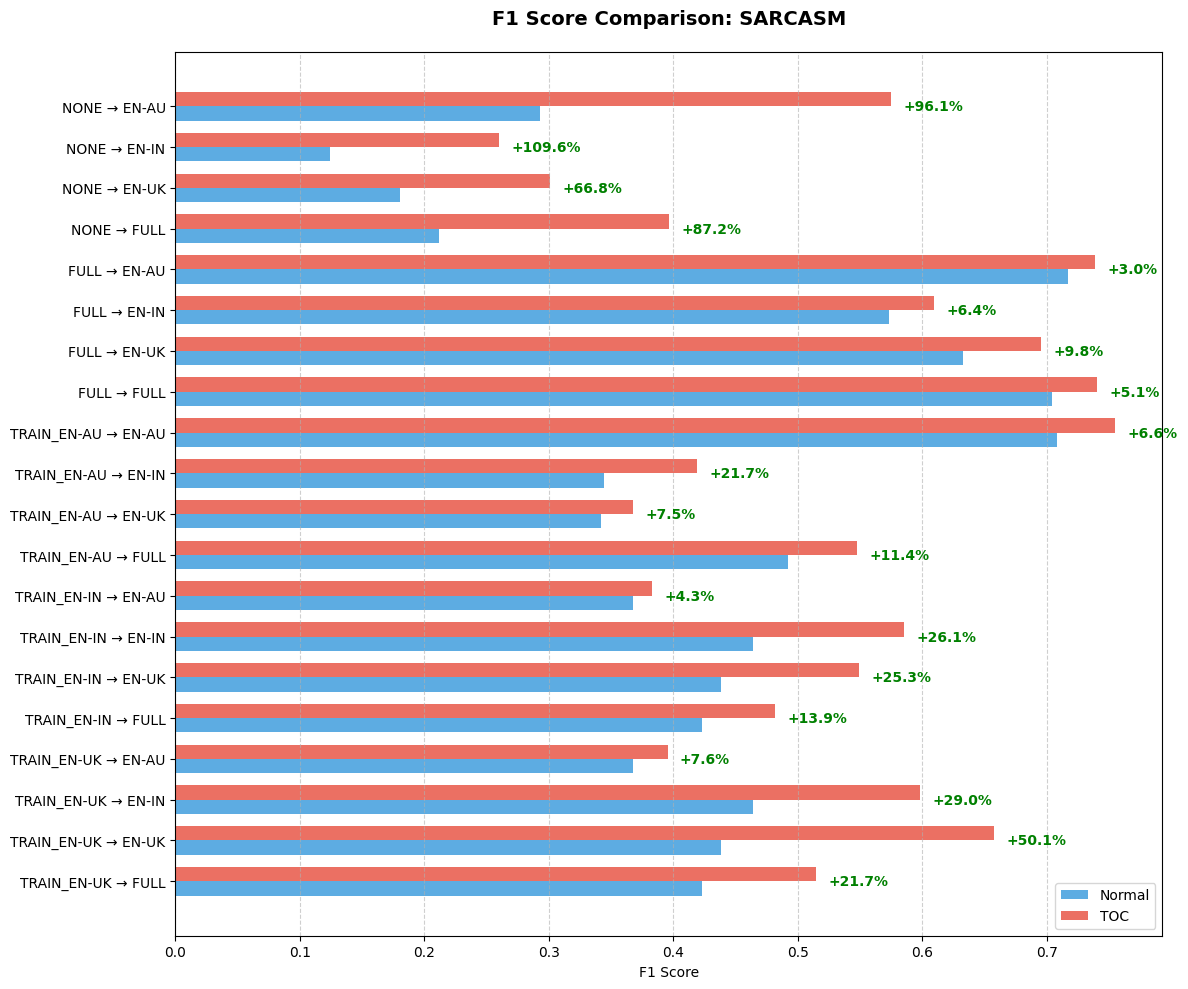

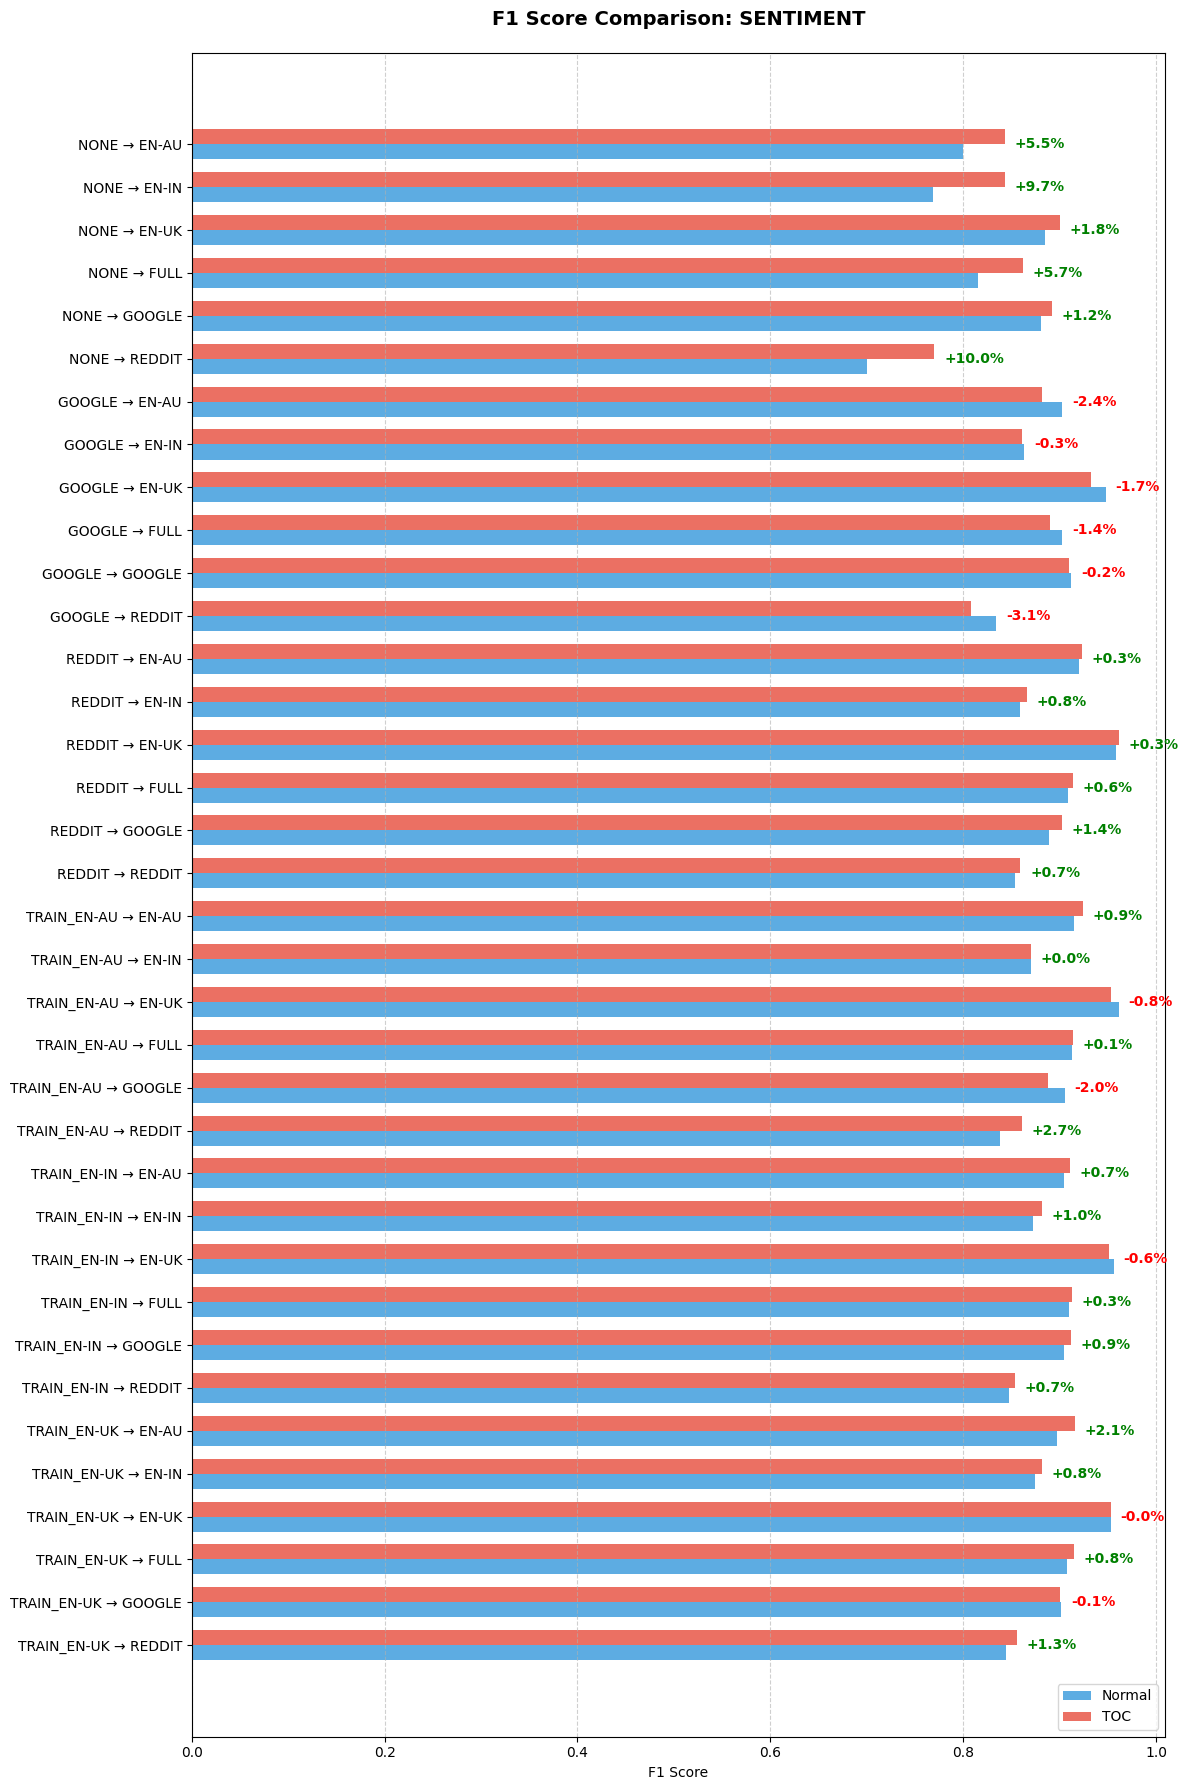

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def generate_comparison_plots(normal_file, toc_file):
    # 1. Load the datasets
    normal_df = pd.read_csv(normal_file)
    toc_df = pd.read_csv(toc_file)

    # 2. Clean and Preprocess Data
    def clean_setting(s):
        if pd.isna(s): return s
        s = str(s).strip().lower()
        if s.endswith('.csv'): s = s[:-4]
        return s

    # Clean NORMAL file
    normal_df = normal_df.dropna(subset=['task', 'f1']).copy()
    normal_df['test_clean'] = normal_df['test_setting'].apply(clean_setting)
    normal_df['train_clean'] = normal_df['train_setting'].apply(lambda x: str(x).strip().lower())

    # Clean TOC file
    toc_df['test_clean'] = toc_df['test_setting'].apply(clean_setting)
    toc_df['train_clean'] = toc_df['train_setting'].apply(lambda x: str(x).strip().lower())

    # 3. Merge Datasets
    merged = pd.merge(
        normal_df[['task', 'train_clean', 'test_clean', 'f1']],
        toc_df[['task', 'train_clean', 'test_clean', 'f1']],
        on=['task', 'train_clean', 'test_clean'],
        suffixes=('_normal', '_toc')
    )

    # 4. Calculate Changes
    merged['pct_change'] = ((merged['f1_toc'] - merged['f1_normal']) / merged['f1_normal']) * 100
    merged['label'] = merged['train_clean'].str.upper() + " → " + merged['test_clean'].str.replace('test_', '').str.upper()

    # 5. Sorting: Pre-trained ('NONE') first, then by task
    merged['priority'] = merged['train_clean'].apply(lambda x: 0 if x == 'none' else 1)
    merged = merged.sort_values(by=['task', 'priority', 'train_clean', 'test_clean'])

    # 6. Plotting
    tasks = merged['task'].unique()
    for task in tasks:
        task_data = merged[merged['task'] == task].copy()

        # Reverse for horizontal plot (matplotlib plots bottom-up)
        task_data = task_data.iloc[::-1]

        labels = task_data['label']
        f1_n = task_data['f1_normal']
        f1_t = task_data['f1_toc']
        pcts = task_data['pct_change']

        y = np.arange(len(labels))
        height = 0.35

        fig, ax = plt.subplots(figsize=(12, max(6, len(labels) * 0.5)))

        rects1 = ax.barh(y - height/2, f1_n, height, label='Normal', color='#3498db', alpha=0.8)
        rects2 = ax.barh(y + height/2, f1_t, height, label='TOC', color='#e74c3c', alpha=0.8)

        # Formatting
        ax.set_title(f'F1 Score Comparison: {task.upper()}', fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('F1 Score')
        ax.set_yticks(y)
        ax.set_yticklabels(labels)
        ax.legend(loc='lower right')
        ax.grid(axis='x', linestyle='--', alpha=0.6)

        # Annotate percentage changes
        for i, pct in enumerate(pcts):
            color = 'green' if pct >= 0 else 'red'
            x_pos = max(f1_n.iloc[i], f1_t.iloc[i]) + 0.01
            ax.text(x_pos, i, f"{pct:+.1f}%", va='center', color=color, fontweight='bold')

        plt.tight_layout()
        # Save or Show
        plt.savefig(f'plot_{task}.png')
        print(f"Saved plot for {task}")

# Run the function
if __name__ == "__main__":
    generate_comparison_plots('/content/drive/MyDrive/DNLP/models/mistral/mistral__BASELINE_besstie_results/all_results.csv', "/content/drive/MyDrive/DNLP/models/mistral/mistral__TOC_HYPERBOLIC_besstie_results/all_results.csv")